# RealNVP Flow Tutorial: Learning to Transform Data Distributions

## What You'll Learn
- What are normalizing flows and why they're useful
- How RealNVP works to transform data distributions
- How to implement a RealNVP model from scratch
- How to train the model and visualize the results

## What is a Normalizing Flow?
A normalizing flow is a type of generative model that learns to transform a simple distribution (like a Gaussian) into a complex distribution (like our moon-shaped data). Think of it like learning to "mold" one shape into another!

## The RealNVP Approach
RealNVP uses "coupling layers" to gradually transform data. Each layer transforms half of the data while keeping the other half unchanged, making the transformation reversible and efficient.

Let's dive in! 🚀


In [1]:
# PyTorch for deep learning
import torch
from torch import nn, optim, distributions
from torch.nn import functional as F

# For data visualization
import matplotlib.pyplot as plt
from pylab import rcParams

# For generating our dataset
from sklearn import datasets
import numpy as np

# For file operations
import os

# Set up plotting parameters
rcParams['figure.figsize'] = 8, 8
plt.ion()  # Interactive plotting

print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Using device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")


✅ All libraries imported successfully!
PyTorch version: 2.9.0+cu126
Using device: CUDA


## Step 2: Configuration and Setup

Step 2 is adjusted for MNIST data

In [2]:
# Training configuration
BATCH_SIZE = 256
EPOCHS = 20
LOG_INTERVAL = 200

# Image size
IMG_H, IMG_W = 28, 28
INPUT_DIM = IMG_H * IMG_W     # 784
OUTPUT_DIM = INPUT_DIM

# Model architecture
HIDDEN_DIM = 512
N_COUPLE_LAYERS = 8

# Split train -> train/val
VAL_SPLIT = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(" Configuration set up!")
print(f"   INPUT_DIM: {INPUT_DIM}")
print(f"   EPOCHS: {EPOCHS}")
print(f"   Device: {device}")

 Configuration set up!
   INPUT_DIM: 784
   EPOCHS: 20
   Device: cuda


## Step 3: Create Our Dataset and Prepare Data Loaders

We'll use MNIST dataset + loaders

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

def make_loaders(dataset_name: str, batch_size: int, val_split: float):
    tfm = transforms.ToTensor()  # images in [0,1], shape [1,28,28]

    if dataset_name.lower() == "mnist":
        ds_full = datasets.MNIST(root="./data", train=True, download=True, transform=tfm)
        ds_test = datasets.MNIST(root="./data", train=False, download=True, transform=tfm)
    elif dataset_name.lower() in ["fashion", "fashionmnist", "fmnist"]:
        ds_full = datasets.FashionMNIST(root="./data", train=True, download=True, transform=tfm)
        ds_test = datasets.FashionMNIST(root="./data", train=False, download=True, transform=tfm)
    else:
        raise ValueError("dataset_name must be: 'mnist' or 'fashionmnist'")

    n_total = len(ds_full)
    n_val = int(n_total * val_split)
    n_train = n_total - n_val
    ds_train, ds_val = random_split(ds_full, [n_train, n_val], generator=torch.Generator().manual_seed(42))

    kwargs = {'num_workers': 2, 'pin_memory': True} if device.type == 'cuda' else {}
    train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True, **kwargs)
    val_loader   = DataLoader(ds_val,   batch_size=batch_size, shuffle=False, **kwargs)
    test_loader  = DataLoader(ds_test,  batch_size=batch_size, shuffle=False, **kwargs)

    return train_loader, val_loader, test_loader

# Example:
train_loader, val_loader, test_loader = make_loaders("mnist", BATCH_SIZE, VAL_SPLIT)
print("MNIST loaders created:", len(train_loader), len(val_loader), len(test_loader))

100%|██████████| 9.91M/9.91M [00:00<00:00, 42.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.02MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.90MB/s]

MNIST loaders created: 211 24 40


## Step 4: Understanding the RealNVP Architecture

Now let's build our RealNVP model! The key idea is to use **coupling layers** that transform data step by step.

### What is a Coupling Layer?
A coupling layer is like a smart transformer that:
1. **Splits** the input data into two parts
2. **Transforms** one part based on the other part
3. **Combines** them back together

This makes the transformation reversible and efficient to compute!

Let's build it step by step:


## Structure of the Coupling Layer Jacobian

In a coupling layer, $x$ is split into two parts by mask $m$:

$$x = (x_m, x_{\bar{m}})$$

**Forward transform:**

$$y_m = x_m$$
$$y_{\bar{m}} = x_{\bar{m}} \odot e^{s(x_m)} + t(x_m)$$

So $y$ depends on $x$ as:

- The first block $y_m$ is just a copy → derivative w.r.t. $x_m$ is identity
- $y_{\bar{m}}$ depends linearly on $x_{\bar{m}}$ but not on $x_m$ except through $s, t$

Let's write the Jacobian matrix $J$ in block form:

$$J = \begin{pmatrix}
\frac{\partial y_m}{\partial x_m} & \frac{\partial y_m}{\partial x_{\bar{m}}} \\
\frac{\partial y_{\bar{m}}}{\partial x_m} & \frac{\partial y_{\bar{m}}}{\partial x_{\bar{m}}}
\end{pmatrix} = \begin{pmatrix}
I & 0 \\
\frac{\partial y_{\bar{m}}}{\partial x_m} & \text{diag}(e^s)
\end{pmatrix}$$

**Key observation:** upper-right block is zero (triangular matrix).

This means:

$$\det J = \det(I) \cdot \det(\text{diag}(e^s)) = 1 \cdot \prod_{i \in \bar{m}} e^{s_i} = e^{\sum_{i \in \bar{m}} s_i}$$

And so:

$$\log |\det J| = \sum_{i \in \bar{m}} s_i$$


## Forward and Inverse Passes

**Forward Pass:**
$x$ with the mask:
- $x_m = m \odot x$ (kept)
- $x_{\bar{m}} = (1-m) \odot x$ (transformed)

You compute $s, t$ from the kept part:
$$s = s_\theta(x_m), \quad t = t_\theta(x_m)$$

Then set:
- $y_m = x_m$ (unchanged)
- $y_{\bar{m}} = x_{\bar{m}} \odot e^s + t$ (transformed)

In the inverse (backward) pass you’re given
$y$. Crucially,


$y_m = x_m$ (the masked coordinates are identical before/after). So the kept part you should condition on is now available as $y_m$. You recompute:
$$s = s_\theta(y_m), \quad t = t_\theta(y_m)$$

And invert:
$$x_{\bar{m}} = (y_{\bar{m}} - t) \odot e^{-s}$$

In [4]:
class CouplingLayer(nn.Module):
    def __init__(self, dim, hid_dim, mask):
        super().__init__()
        self.register_buffer("mask", mask)  # stays with model on device

        # s,t networks map R^dim -> R^dim, but only unmasked part will be applied
        self.s_net = nn.Sequential(
            nn.Linear(dim, hid_dim), nn.ReLU(),
            nn.Linear(hid_dim, hid_dim), nn.ReLU(),
            nn.Linear(hid_dim, dim), nn.Tanh()
        )
        self.t_net = nn.Sequential(
            nn.Linear(dim, hid_dim), nn.ReLU(),
            nn.Linear(hid_dim, hid_dim), nn.ReLU(),
            nn.Linear(hid_dim, dim)
        )

    def forward(self, x):
        x_m = x * self.mask
        s = self.s_net(x_m)
        t = self.t_net(x_m)

        y = x_m + (1 - self.mask) * (x * torch.exp(s) + t)

        # ✅ correct logdet: only transformed dims contribute
        log_det = ((1 - self.mask) * s).sum(dim=1)
        return y, log_det

    def backward(self, y):
        y_m = y * self.mask
        s = self.s_net(y_m)
        t = self.t_net(y_m)
        x = y_m + (1 - self.mask) * (y - t) * torch.exp(-s)
        return x

print("CouplingLayer class defined!")
print("This is the building block of our RealNVP flow.")

CouplingLayer class defined!
This is the building block of our RealNVP flow.


Now let's build the complete RealNVP model by combining multiple coupling layers:


In [5]:
class RealNVP(nn.Module):
    def __init__(self, dim, hid_dim, n_layers):
        super().__init__()
        assert n_layers >= 2

        # alternating binary mask (half dims fixed, half transformed)
        base_mask = torch.zeros(dim)
        base_mask[::2] = 1.0  # keep even indices, transform odd

        layers = []
        mask = base_mask
        for _ in range(n_layers):
            layers.append(CouplingLayer(dim=dim, hid_dim=hid_dim, mask=mask))
            mask = 1 - mask  # flip
        self.coupling_layers = nn.ModuleList(layers)

        self.prior = distributions.MultivariateNormal(
            torch.zeros(dim, device=device),
            torch.eye(dim, device=device)
        )

    def forward(self, x):
        ldj_sum = torch.zeros(x.size(0), device=x.device)
        for layer in self.coupling_layers:
            x, ldj = layer(x)
            ldj_sum += ldj
        return x, ldj_sum

    def backward(self, z):
        for layer in reversed(self.coupling_layers):
            z = layer.backward(z)
        return z

    def log_prob(self, x):
        z, ldj = self.forward(x)
        return self.prior.log_prob(z) + ldj

    @torch.no_grad()
    def sample(self, n):
        z = self.prior.sample((n,))
        x = self.backward(z)
        return x

print("RealNVP class defined!")
print("This combines multiple coupling layers into a complete flow model.")

RealNVP class defined!
This combines multiple coupling layers into a complete flow model.


Now let's create our model and set up the training components:


## Step 5: Training Functions

Now let's create the functions that will train our model. The key idea is to minimize the negative log-likelihood, which encourages our model to transform the complex data into a simple Gaussian distribution.


In [6]:
from torchvision.utils import make_grid

def preprocess_batch(images):
    # images: [B,1,28,28] in [0,1]
    x = images.view(images.size(0), -1).to(device)
    # optional: add small uniform noise for dequantization
    x = x + torch.rand_like(x) / 256.0
    x = torch.clamp(x, 0.0, 1.0)
    return x

@torch.no_grad()
def evaluate_nll(model, loader):
    model.eval()
    total_nll = 0.0
    total_count = 0
    for images, _ in loader:
        x = preprocess_batch(images)
        nll = -(model.log_prob(x))  # [B]
        total_nll += nll.sum().item()
        total_count += x.size(0)

    avg_nll = total_nll / total_count
    # bits per dim (common metric for flows on images)
    bpd = avg_nll / (np.log(2) * INPUT_DIM)
    return avg_nll, bpd

def train_one_epoch(model, loader, optimizer):
    model.train()
    total_nll = 0.0
    total_count = 0

    for batch_idx, (images, _) in enumerate(loader):
        x = preprocess_batch(images)
        optimizer.zero_grad()
        loss = -(model.log_prob(x)).mean()
        loss.backward()
        optimizer.step()

        total_nll += loss.item() * x.size(0)
        total_count += x.size(0)

        if batch_idx % LOG_INTERVAL == 0:
            print(f"batch {batch_idx}/{len(loader)} loss={loss.item():.4f}")

    avg_nll = total_nll / total_count
    bpd = avg_nll / (np.log(2) * INPUT_DIM)
    return avg_nll, bpd

@torch.no_grad()
def show_samples(model, title, n=64):
    model.eval()
    x = model.sample(n)                       # [n,784]
    x = x.view(n, 1, 28, 28).cpu()
    grid = make_grid(x, nrow=8)
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1,2,0).squeeze(), cmap="gray")
    plt.axis("off")
    plt.title(title)
    plt.show()

def run_experiment(dataset_name: str):
    print("\n" + "="*60)
    print(f"🚀 Running RealNVP on: {dataset_name}")
    print("="*60)

    train_loader, val_loader, test_loader = make_loaders(dataset_name, BATCH_SIZE, VAL_SPLIT)

    model = RealNVP(dim=INPUT_DIM, hid_dim=HIDDEN_DIM, n_layers=N_COUPLE_LAYERS).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    history = {"train_nll": [], "val_nll": [], "train_bpd": [], "val_bpd": []}

    for epoch in range(1, EPOCHS + 1):
        print(f"\nEpoch {epoch}/{EPOCHS}")

        tr_nll, tr_bpd = train_one_epoch(model, train_loader, optimizer)
        va_nll, va_bpd = evaluate_nll(model, val_loader)

        history["train_nll"].append(tr_nll)
        history["train_bpd"].append(tr_bpd)
        history["val_nll"].append(va_nll)
        history["val_bpd"].append(va_bpd)

        print(f"train_nll={tr_nll:.4f}  train_bpd={tr_bpd:.6f}")
        print(f"val_nll  ={va_nll:.4f}  val_bpd  ={va_bpd:.6f}")

        if epoch % 5 == 0 or epoch == 1:
            show_samples(model, title=f"{dataset_name} samples (epoch {epoch})", n=64)

    # Final test evaluation
    te_nll, te_bpd = evaluate_nll(model, test_loader)
    print("\nFinal TEST metrics:")
    print(f"test_nll={te_nll:.4f}")
    print(f"test_bpd={te_bpd:.6f}")

    # Plot curves
    plt.figure(figsize=(10,4))
    plt.plot(history["train_bpd"], label="train_bpd")
    plt.plot(history["val_bpd"], label="val_bpd")
    plt.grid(True); plt.legend(); plt.title(f"{dataset_name} - Bits/Dim"); plt.show()

    return model, history


🚀 Running RealNVP on: mnist

Epoch 1/100
batch 0/211 loss=768.5121
batch 200/211 loss=-1325.5079
train_nll=-802.4911  train_bpd=-1.476722
val_nll  =-1366.0947  val_bpd  =-2.513850


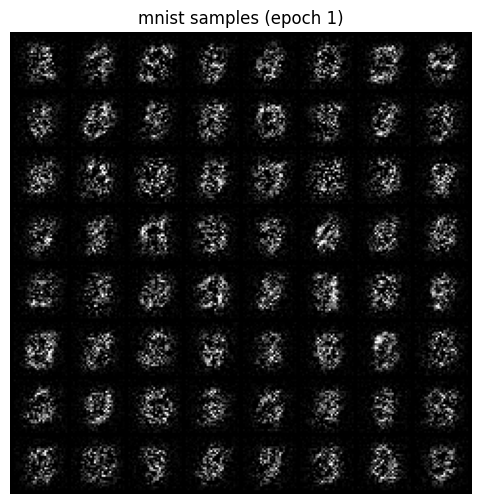


Epoch 2/100
batch 0/211 loss=-1374.1238
batch 200/211 loss=-1520.9698
train_nll=-1462.4580  train_bpd=-2.691175
val_nll  =-1525.8662  val_bpd  =-2.807857

Epoch 3/100
batch 0/211 loss=-1526.5112
batch 200/211 loss=-1625.4143
train_nll=-1571.2490  train_bpd=-2.891369
val_nll  =-1599.8593  val_bpd  =-2.944017

Epoch 4/100
batch 0/211 loss=-1591.0353
batch 200/211 loss=-1647.0497
train_nll=-1631.6101  train_bpd=-3.002444
val_nll  =-1640.9857  val_bpd  =-3.019696

Epoch 5/100
batch 0/211 loss=-1661.5569
batch 200/211 loss=-1672.7380


train_nll=-1673.3419  train_bpd=-3.079237
val_nll  =-1679.2930  val_bpd  =-3.090188


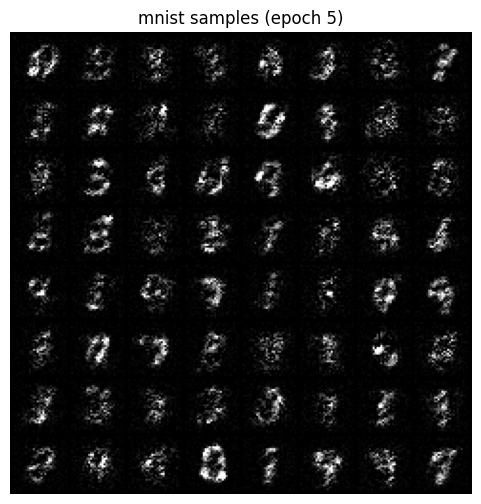


Epoch 6/100
batch 0/211 loss=-1692.8394
batch 200/211 loss=-1720.9548
train_nll=-1705.3426  train_bpd=-3.138124
val_nll  =-1705.0313  val_bpd  =-3.137551

Epoch 7/100
batch 0/211 loss=-1732.2271
batch 200/211 loss=-1747.9583
train_nll=-1731.0870  train_bpd=-3.185498
val_nll  =-1728.9379  val_bpd  =-3.181544

Epoch 8/100
batch 0/211 loss=-1715.4781
batch 200/211 loss=-1751.7543
train_nll=-1753.4813  train_bpd=-3.226708
val_nll  =-1745.8940  val_bpd  =-3.212746

Epoch 9/100
batch 0/211 loss=-1749.7271
batch 200/211 loss=-1770.2382
train_nll=-1771.6588  train_bpd=-3.260157
val_nll  =-1756.1413  val_bpd  =-3.231603

Epoch 10/100
batch 0/211 loss=-1785.2253
batch 200/211 loss=-1780.8611


train_nll=-1787.0207  train_bpd=-3.288426
val_nll  =-1773.9562  val_bpd  =-3.264385


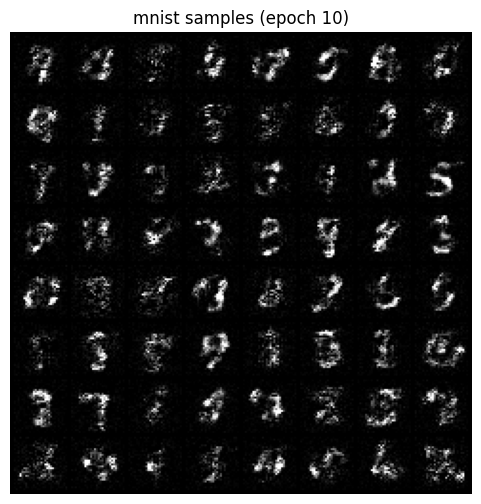


Epoch 11/100
batch 0/211 loss=-1801.4291
batch 200/211 loss=-1811.2407
train_nll=-1800.7909  train_bpd=-3.313765
val_nll  =-1785.9308  val_bpd  =-3.286420

Epoch 12/100
batch 0/211 loss=-1807.4714
batch 200/211 loss=-1818.6575
train_nll=-1813.1661  train_bpd=-3.336538
val_nll  =-1795.0002  val_bpd  =-3.303110

Epoch 13/100
batch 0/211 loss=-1826.6245
batch 200/211 loss=-1823.8889
train_nll=-1823.9756  train_bpd=-3.356429
val_nll  =-1799.5201  val_bpd  =-3.311427

Epoch 14/100
batch 0/211 loss=-1815.9539
batch 200/211 loss=-1863.3943
train_nll=-1833.7214  train_bpd=-3.374363
val_nll  =-1806.5867  val_bpd  =-3.324431

Epoch 15/100
batch 0/211 loss=-1829.1205
batch 200/211 loss=-1838.8655


train_nll=-1842.2635  train_bpd=-3.390082
val_nll  =-1818.7221  val_bpd  =-3.346762


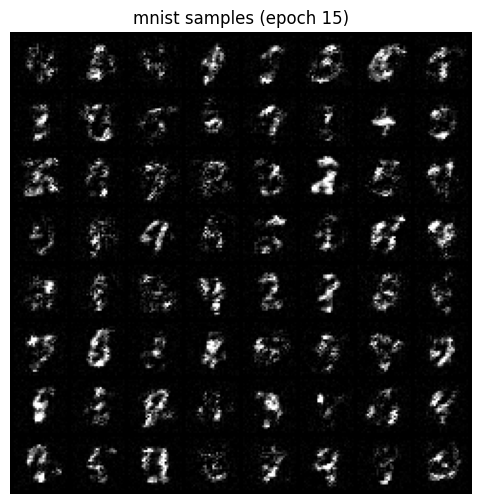


Epoch 16/100
batch 0/211 loss=-1854.5576
batch 200/211 loss=-1863.9438
train_nll=-1850.7723  train_bpd=-3.405740
val_nll  =-1823.0791  val_bpd  =-3.354780

Epoch 17/100
batch 0/211 loss=-1843.4009
batch 200/211 loss=-1847.2385
train_nll=-1856.6468  train_bpd=-3.416550
val_nll  =-1829.4214  val_bpd  =-3.366450

Epoch 18/100
batch 0/211 loss=-1848.5956
batch 200/211 loss=-1864.8811
train_nll=-1864.7543  train_bpd=-3.431469
val_nll  =-1834.5683  val_bpd  =-3.375922

Epoch 19/100
batch 0/211 loss=-1870.5415
batch 200/211 loss=-1886.1904
train_nll=-1870.9979  train_bpd=-3.442958
val_nll  =-1836.6560  val_bpd  =-3.379763

Epoch 20/100
batch 0/211 loss=-1876.1772
batch 200/211 loss=-1871.5713


train_nll=-1876.0077  train_bpd=-3.452177
val_nll  =-1844.3081  val_bpd  =-3.393845


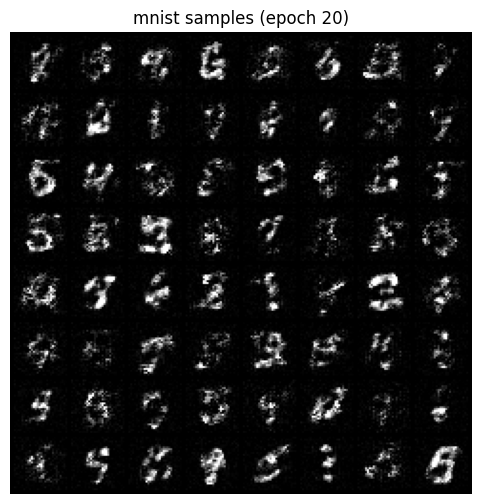


Epoch 21/100
batch 0/211 loss=-1875.5852
batch 200/211 loss=-1896.3549
train_nll=-1882.1661  train_bpd=-3.463510
val_nll  =-1844.7745  val_bpd  =-3.394703

Epoch 22/100
batch 0/211 loss=-1880.7783
batch 200/211 loss=-1900.0233
train_nll=-1886.7131  train_bpd=-3.471877
val_nll  =-1850.8111  val_bpd  =-3.405811

Epoch 23/100
batch 0/211 loss=-1899.0723
batch 200/211 loss=-1889.5496
train_nll=-1892.1546  train_bpd=-3.481890
val_nll  =-1848.4865  val_bpd  =-3.401534

Epoch 24/100
batch 0/211 loss=-1910.0210
batch 200/211 loss=-1893.7410
train_nll=-1896.2577  train_bpd=-3.489441
val_nll  =-1859.7575  val_bpd  =-3.422274

Epoch 25/100
batch 0/211 loss=-1897.4270
batch 200/211 loss=-1897.5510


train_nll=-1899.6344  train_bpd=-3.495655
val_nll  =-1860.9218  val_bpd  =-3.424417


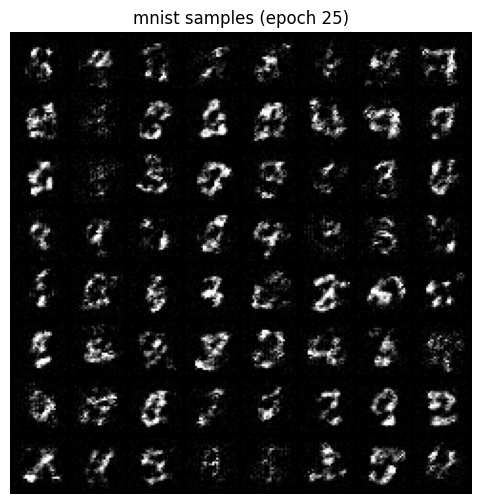


Epoch 26/100
batch 0/211 loss=-1922.0955
batch 200/211 loss=-1897.0271
train_nll=-1904.2179  train_bpd=-3.504089
val_nll  =-1861.3356  val_bpd  =-3.425178

Epoch 27/100
batch 0/211 loss=-1904.0681
batch 200/211 loss=-1908.9070
train_nll=-1908.3018  train_bpd=-3.511604
val_nll  =-1866.4903  val_bpd  =-3.434664

Epoch 28/100
batch 0/211 loss=-1923.8164
batch 200/211 loss=-1907.0391
train_nll=-1911.8291  train_bpd=-3.518095
val_nll  =-1868.2054  val_bpd  =-3.437820

Epoch 29/100
batch 0/211 loss=-1918.6578
batch 200/211 loss=-1915.5844
train_nll=-1914.7975  train_bpd=-3.523557
val_nll  =-1868.1324  val_bpd  =-3.437685

Epoch 30/100
batch 0/211 loss=-1929.3774
batch 200/211 loss=-1927.9199


train_nll=-1917.9756  train_bpd=-3.529405
val_nll  =-1868.6130  val_bpd  =-3.438570


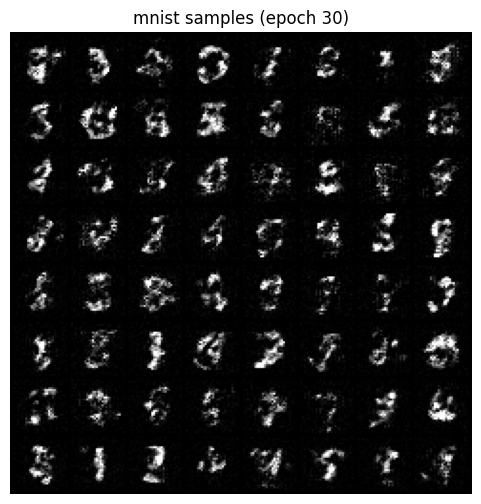


Epoch 31/100
batch 0/211 loss=-1912.9775
batch 200/211 loss=-1930.4456
train_nll=-1921.9736  train_bpd=-3.536763
val_nll  =-1875.5435  val_bpd  =-3.451323

Epoch 32/100
batch 0/211 loss=-1920.3601
batch 200/211 loss=-1940.2937
train_nll=-1924.3308  train_bpd=-3.541100
val_nll  =-1873.9190  val_bpd  =-3.448334

Epoch 33/100
batch 0/211 loss=-1937.3132
batch 200/211 loss=-1929.9692
train_nll=-1927.1587  train_bpd=-3.546304
val_nll  =-1868.7676  val_bpd  =-3.438854

Epoch 34/100
batch 0/211 loss=-1938.2000
batch 200/211 loss=-1922.5319
train_nll=-1930.2838  train_bpd=-3.552055
val_nll  =-1876.2684  val_bpd  =-3.452657

Epoch 35/100
batch 0/211 loss=-1929.4935
batch 200/211 loss=-1935.9634


train_nll=-1931.9236  train_bpd=-3.555072
val_nll  =-1880.4908  val_bpd  =-3.460427


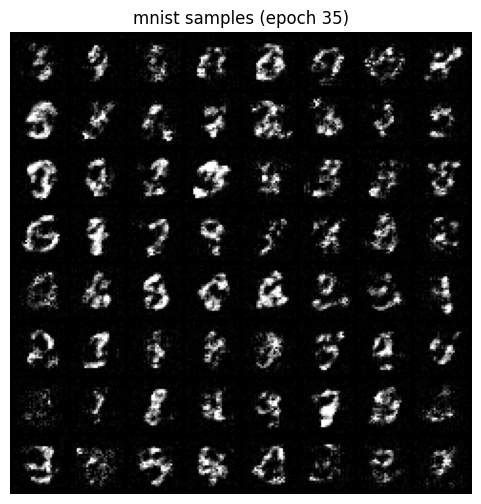


Epoch 36/100
batch 0/211 loss=-1940.6038
batch 200/211 loss=-1939.8207
train_nll=-1935.9312  train_bpd=-3.562447
val_nll  =-1880.3205  val_bpd  =-3.460114

Epoch 37/100
batch 0/211 loss=-1945.4417
batch 200/211 loss=-1922.8199
train_nll=-1938.1374  train_bpd=-3.566507
val_nll  =-1880.8457  val_bpd  =-3.461080

Epoch 38/100
batch 0/211 loss=-1943.3499
batch 200/211 loss=-1943.5049
train_nll=-1940.5687  train_bpd=-3.570981
val_nll  =-1882.5196  val_bpd  =-3.464160

Epoch 39/100
batch 0/211 loss=-1935.9492
batch 200/211 loss=-1947.8987
train_nll=-1942.2262  train_bpd=-3.574031
val_nll  =-1881.0524  val_bpd  =-3.461460

Epoch 40/100
batch 0/211 loss=-1954.0862
batch 200/211 loss=-1954.4760


train_nll=-1945.3426  train_bpd=-3.579765
val_nll  =-1887.6714  val_bpd  =-3.473640


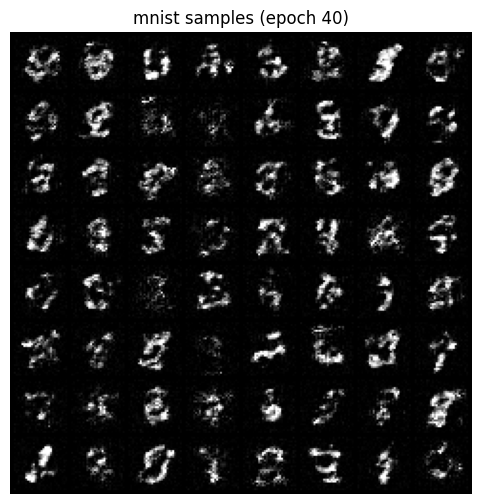


Epoch 41/100
batch 0/211 loss=-1951.2679
batch 200/211 loss=-1927.7546
train_nll=-1947.2043  train_bpd=-3.583191
val_nll  =-1882.2985  val_bpd  =-3.463753

Epoch 42/100
batch 0/211 loss=-1945.4706
batch 200/211 loss=-1948.7925
train_nll=-1949.1795  train_bpd=-3.586826
val_nll  =-1889.2258  val_bpd  =-3.476501

Epoch 43/100
batch 0/211 loss=-1950.3488
batch 200/211 loss=-1949.8058
train_nll=-1952.0539  train_bpd=-3.592115
val_nll  =-1884.5219  val_bpd  =-3.467845

Epoch 44/100
batch 0/211 loss=-1940.7397
batch 200/211 loss=-1954.8113
train_nll=-1953.4401  train_bpd=-3.594666
val_nll  =-1883.9413  val_bpd  =-3.466777

Epoch 45/100
batch 0/211 loss=-1941.3894
batch 200/211 loss=-1955.6893


train_nll=-1955.8942  train_bpd=-3.599182
val_nll  =-1896.6114  val_bpd  =-3.490092


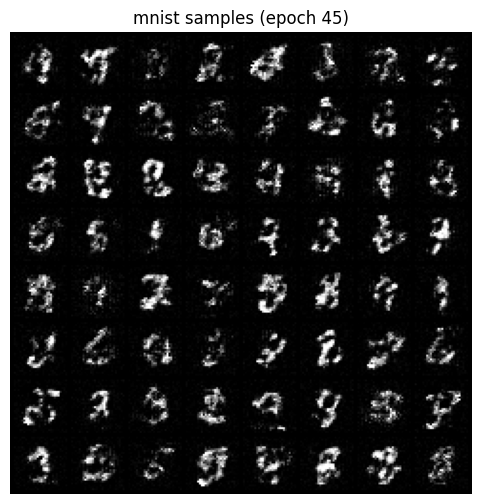


Epoch 46/100
batch 0/211 loss=-1950.5447
batch 200/211 loss=-1953.9290
train_nll=-1957.7246  train_bpd=-3.602550
val_nll  =-1890.5591  val_bpd  =-3.478954

Epoch 47/100
batch 0/211 loss=-1962.8401
batch 200/211 loss=-1955.5352
train_nll=-1959.5626  train_bpd=-3.605933
val_nll  =-1892.4253  val_bpd  =-3.482389

Epoch 48/100
batch 0/211 loss=-1969.0479
batch 200/211 loss=-1954.3118
train_nll=-1960.1398  train_bpd=-3.606995
val_nll  =-1887.7544  val_bpd  =-3.473793

Epoch 49/100
batch 0/211 loss=-1958.2798
batch 200/211 loss=-1958.5649
train_nll=-1962.9973  train_bpd=-3.612253
val_nll  =-1897.0832  val_bpd  =-3.490960

Epoch 50/100
batch 0/211 loss=-1964.9495
batch 200/211 loss=-1983.2908


train_nll=-1964.9005  train_bpd=-3.615755
val_nll  =-1890.5695  val_bpd  =-3.478974


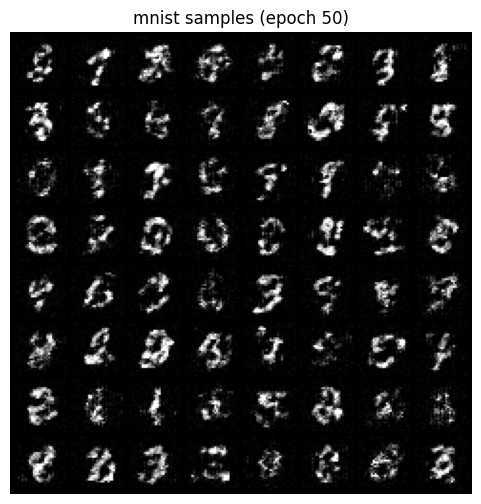


Epoch 51/100
batch 0/211 loss=-1968.1279
batch 200/211 loss=-1975.1631
train_nll=-1966.6346  train_bpd=-3.618946
val_nll  =-1897.6452  val_bpd  =-3.491994

Epoch 52/100
batch 0/211 loss=-1976.5306
batch 200/211 loss=-1977.9976
train_nll=-1968.2770  train_bpd=-3.621969
val_nll  =-1896.8884  val_bpd  =-3.490601

Epoch 53/100
batch 0/211 loss=-1976.2197
batch 200/211 loss=-1972.3564
train_nll=-1970.2402  train_bpd=-3.625581
val_nll  =-1896.5885  val_bpd  =-3.490049

Epoch 54/100
batch 0/211 loss=-1965.6715
batch 200/211 loss=-1965.6542
train_nll=-1971.7228  train_bpd=-3.628309
val_nll  =-1896.6114  val_bpd  =-3.490092

Epoch 55/100
batch 0/211 loss=-1977.0293
batch 200/211 loss=-1974.3969


train_nll=-1972.9634  train_bpd=-3.630593
val_nll  =-1887.7139  val_bpd  =-3.473719


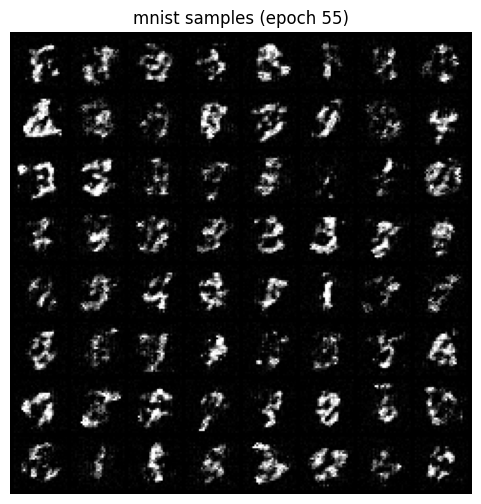


Epoch 56/100
batch 0/211 loss=-1965.1389
batch 200/211 loss=-1961.6831
train_nll=-1972.5184  train_bpd=-3.629774
val_nll  =-1900.0527  val_bpd  =-3.496424

Epoch 57/100
batch 0/211 loss=-1993.2915
batch 200/211 loss=-1973.4160
train_nll=-1976.2853  train_bpd=-3.636705
val_nll  =-1900.7633  val_bpd  =-3.497732

Epoch 58/100
batch 0/211 loss=-1980.7078
batch 200/211 loss=-1972.0505
train_nll=-1977.0755  train_bpd=-3.638159
val_nll  =-1897.5924  val_bpd  =-3.491897

Epoch 59/100
batch 0/211 loss=-1973.7866
batch 200/211 loss=-1971.0031
train_nll=-1978.7512  train_bpd=-3.641243
val_nll  =-1902.6411  val_bpd  =-3.501187

Epoch 60/100
batch 0/211 loss=-1981.2551
batch 200/211 loss=-1974.4894


train_nll=-1980.2520  train_bpd=-3.644005
val_nll  =-1901.0973  val_bpd  =-3.498346


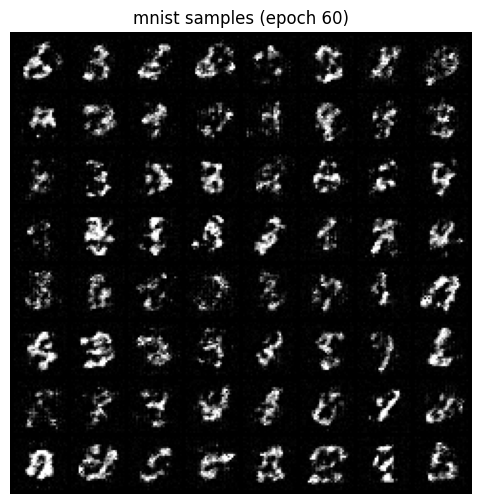


Epoch 61/100
batch 0/211 loss=-1980.1833
batch 200/211 loss=-1992.2012
train_nll=-1981.7428  train_bpd=-3.646748
val_nll  =-1897.2423  val_bpd  =-3.491253

Epoch 62/100
batch 0/211 loss=-1985.2299
batch 200/211 loss=-1983.7117
train_nll=-1982.6661  train_bpd=-3.648447
val_nll  =-1902.9653  val_bpd  =-3.501784

Epoch 63/100
batch 0/211 loss=-1991.9178
batch 200/211 loss=-1977.7245
train_nll=-1983.7656  train_bpd=-3.650470
val_nll  =-1903.0952  val_bpd  =-3.502023

Epoch 64/100
batch 0/211 loss=-1990.1927
batch 200/211 loss=-1985.7860
train_nll=-1985.4557  train_bpd=-3.653580
val_nll  =-1901.9595  val_bpd  =-3.499933

Epoch 65/100
batch 0/211 loss=-1985.3641
batch 200/211 loss=-1980.1571


train_nll=-1986.8578  train_bpd=-3.656161
val_nll  =-1898.1717  val_bpd  =-3.492963


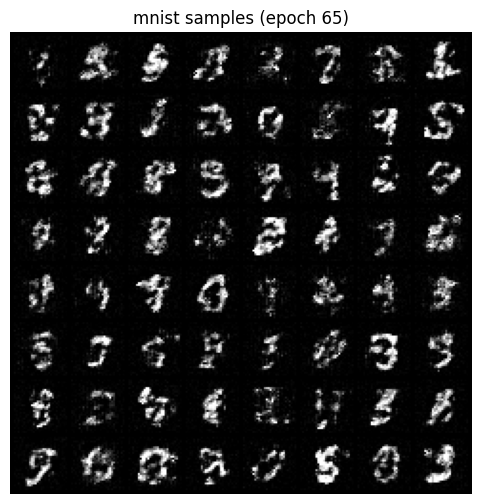


Epoch 66/100
batch 0/211 loss=-1993.8116
batch 200/211 loss=-1982.4877
train_nll=-1987.5099  train_bpd=-3.657361
val_nll  =-1899.1143  val_bpd  =-3.494697

Epoch 67/100
batch 0/211 loss=-1988.0383
batch 200/211 loss=-1998.2498
train_nll=-1989.2389  train_bpd=-3.660542
val_nll  =-1903.0016  val_bpd  =-3.501851

Epoch 68/100
batch 0/211 loss=-1994.2166
batch 200/211 loss=-1997.9320
train_nll=-1990.0864  train_bpd=-3.662102
val_nll  =-1903.8227  val_bpd  =-3.503362

Epoch 69/100
batch 0/211 loss=-1984.4879
batch 200/211 loss=-1983.9596
train_nll=-1990.7179  train_bpd=-3.663264
val_nll  =-1899.9814  val_bpd  =-3.496293

Epoch 70/100
batch 0/211 loss=-1996.3914
batch 200/211 loss=-1998.9307


train_nll=-1992.5203  train_bpd=-3.666580
val_nll  =-1903.5109  val_bpd  =-3.502788


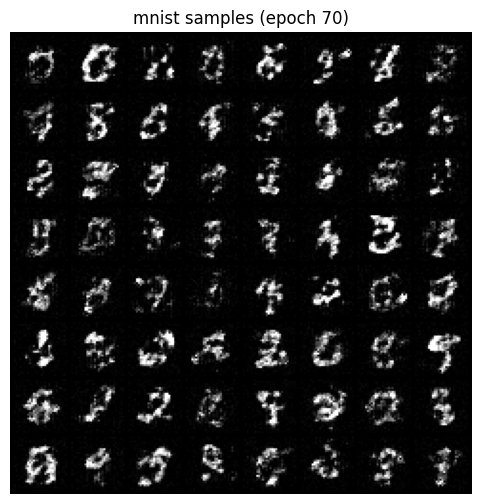


Epoch 71/100
batch 0/211 loss=-1997.7676
batch 200/211 loss=-1995.9590
train_nll=-1993.2963  train_bpd=-3.668008
val_nll  =-1898.1067  val_bpd  =-3.492843

Epoch 72/100
batch 0/211 loss=-1984.5896
batch 200/211 loss=-1991.7073
train_nll=-1994.5855  train_bpd=-3.670381
val_nll  =-1902.8252  val_bpd  =-3.501526

Epoch 73/100
batch 0/211 loss=-2006.9531
batch 200/211 loss=-1977.3035
train_nll=-1995.6957  train_bpd=-3.672424
val_nll  =-1904.3578  val_bpd  =-3.504346

Epoch 74/100
batch 0/211 loss=-1983.1333
batch 200/211 loss=-1998.7690
train_nll=-1996.7677  train_bpd=-3.674397
val_nll  =-1903.6476  val_bpd  =-3.503040

Epoch 75/100
batch 0/211 loss=-2011.5332
batch 200/211 loss=-1996.8732


train_nll=-1997.0631  train_bpd=-3.674940
val_nll  =-1900.4270  val_bpd  =-3.497113


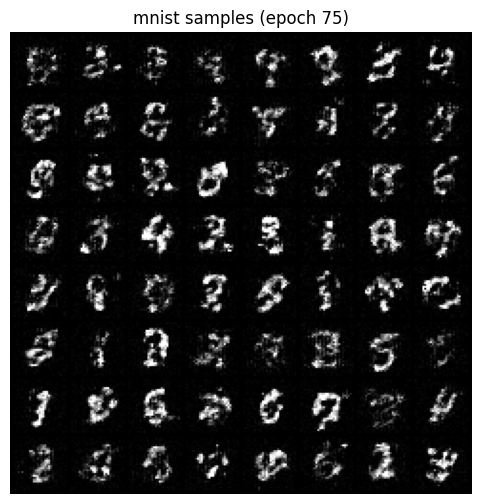


Epoch 76/100
batch 0/211 loss=-1996.5791
batch 200/211 loss=-2007.8621
train_nll=-1998.0746  train_bpd=-3.676801
val_nll  =-1901.0664  val_bpd  =-3.498290

Epoch 77/100
batch 0/211 loss=-1994.8081
batch 200/211 loss=-2003.3158
train_nll=-1999.7922  train_bpd=-3.679962
val_nll  =-1897.9295  val_bpd  =-3.492517

Epoch 78/100
batch 0/211 loss=-2005.6111
batch 200/211 loss=-1990.4874
train_nll=-2000.6394  train_bpd=-3.681521
val_nll  =-1901.0071  val_bpd  =-3.498180

Epoch 79/100
batch 0/211 loss=-2004.9412
batch 200/211 loss=-2000.3169
train_nll=-2001.9925  train_bpd=-3.684011
val_nll  =-1904.1267  val_bpd  =-3.503921

Epoch 80/100
batch 0/211 loss=-2007.1768
batch 200/211 loss=-2005.4067


train_nll=-2002.4523  train_bpd=-3.684857
val_nll  =-1903.4262  val_bpd  =-3.502632


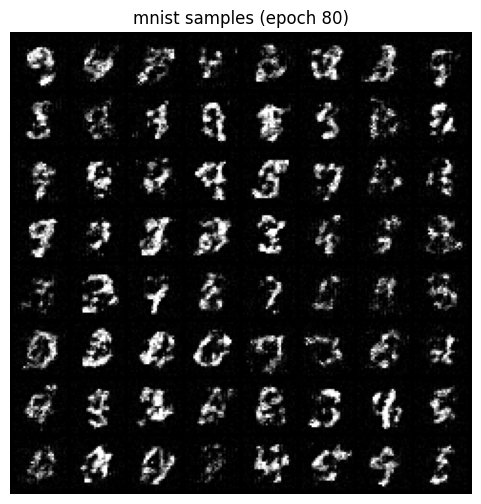


Epoch 81/100
batch 0/211 loss=-2008.3022
batch 200/211 loss=-2008.7925
train_nll=-2003.4575  train_bpd=-3.686707
val_nll  =-1899.8369  val_bpd  =-3.496027

Epoch 82/100
batch 0/211 loss=-1999.8141
batch 200/211 loss=-2012.9158
train_nll=-2004.3847  train_bpd=-3.688413
val_nll  =-1895.6240  val_bpd  =-3.488275

Epoch 83/100
batch 0/211 loss=-1997.2795
batch 200/211 loss=-2007.0679
train_nll=-2005.4697  train_bpd=-3.690410
val_nll  =-1898.0138  val_bpd  =-3.492672

Epoch 84/100
batch 0/211 loss=-2022.1704
batch 200/211 loss=-2006.2068
train_nll=-2005.9178  train_bpd=-3.691234
val_nll  =-1904.6122  val_bpd  =-3.504814

Epoch 85/100
batch 0/211 loss=-2007.9141
batch 200/211 loss=-2016.6213


train_nll=-2007.2375  train_bpd=-3.693663
val_nll  =-1899.3947  val_bpd  =-3.495213


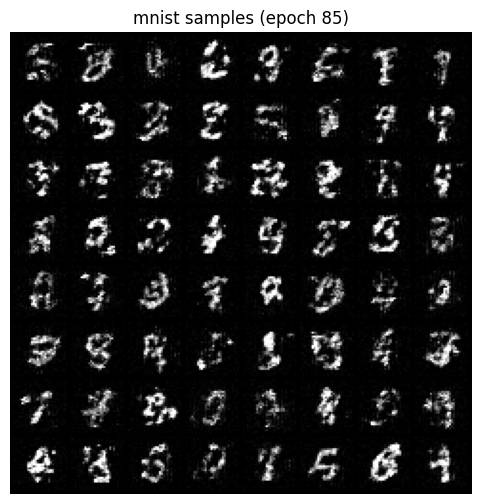


Epoch 86/100
batch 0/211 loss=-2002.7590
batch 200/211 loss=-2008.9939
train_nll=-2007.5909  train_bpd=-3.694313
val_nll  =-1904.9022  val_bpd  =-3.505348

Epoch 87/100
batch 0/211 loss=-2000.7234
batch 200/211 loss=-2030.1213
train_nll=-2008.0258  train_bpd=-3.695113
val_nll  =-1905.2484  val_bpd  =-3.505985

Epoch 88/100
batch 0/211 loss=-2011.8892
batch 200/211 loss=-1999.2789
train_nll=-2009.1884  train_bpd=-3.697253
val_nll  =-1900.5383  val_bpd  =-3.497318

Epoch 89/100
batch 0/211 loss=-2009.3743
batch 200/211 loss=-1997.0684
train_nll=-2010.0315  train_bpd=-3.698804
val_nll  =-1899.6117  val_bpd  =-3.495613

Epoch 90/100
batch 0/211 loss=-2003.7346
batch 200/211 loss=-1988.8179


train_nll=-2008.5492  train_bpd=-3.696076
val_nll  =-1907.3547  val_bpd  =-3.509861


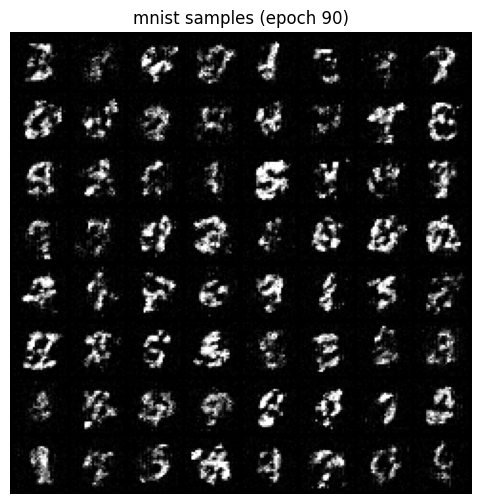


Epoch 91/100
batch 0/211 loss=-2000.3369
batch 200/211 loss=-2008.2776
train_nll=-2009.1311  train_bpd=-3.697147
val_nll  =-1896.5591  val_bpd  =-3.489995

Epoch 92/100
batch 0/211 loss=-2019.8799
batch 200/211 loss=-2009.7107
train_nll=-2012.6393  train_bpd=-3.703603
val_nll  =-1897.4155  val_bpd  =-3.491571

Epoch 93/100
batch 0/211 loss=-2016.7252
batch 200/211 loss=-2020.9020
train_nll=-2013.3399  train_bpd=-3.704892
val_nll  =-1905.7136  val_bpd  =-3.506841

Epoch 94/100
batch 0/211 loss=-2005.8264
batch 200/211 loss=-2000.7545
train_nll=-2014.1142  train_bpd=-3.706317
val_nll  =-1898.2775  val_bpd  =-3.493158

Epoch 95/100
batch 0/211 loss=-2005.6069
batch 200/211 loss=-2016.4991


train_nll=-2015.5348  train_bpd=-3.708931
val_nll  =-1897.9130  val_bpd  =-3.492487


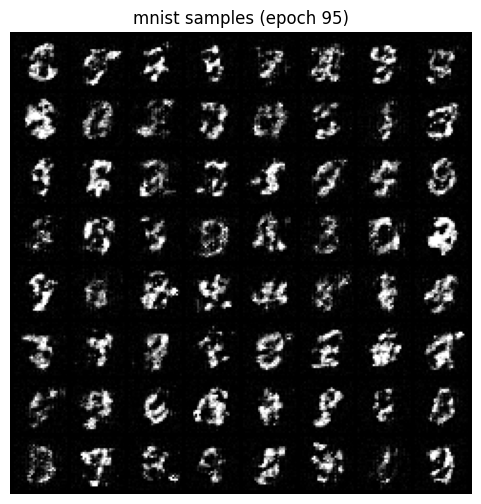


Epoch 96/100
batch 0/211 loss=-2015.0776
batch 200/211 loss=-2013.9841
train_nll=-2015.6303  train_bpd=-3.709107
val_nll  =-1901.8039  val_bpd  =-3.499647

Epoch 97/100
batch 0/211 loss=-2008.5134
batch 200/211 loss=-2010.6097
train_nll=-2016.3129  train_bpd=-3.710363
val_nll  =-1899.8028  val_bpd  =-3.495964

Epoch 98/100
batch 0/211 loss=-2012.3000
batch 200/211 loss=-2017.5601
train_nll=-2017.1619  train_bpd=-3.711925
val_nll  =-1899.7550  val_bpd  =-3.495876

Epoch 99/100
batch 0/211 loss=-2012.6051
batch 200/211 loss=-2007.3002
train_nll=-2018.1559  train_bpd=-3.713754
val_nll  =-1905.1884  val_bpd  =-3.505875

Epoch 100/100
batch 0/211 loss=-2021.5317
batch 200/211 loss=-2013.5614


train_nll=-2018.3433  train_bpd=-3.714099
val_nll  =-1896.0637  val_bpd  =-3.489084


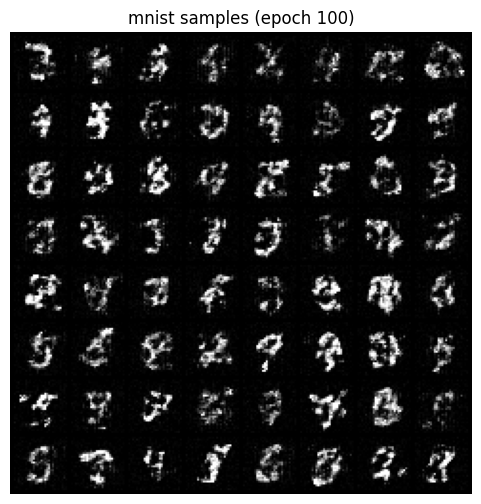


Final TEST metrics:
test_nll=-1890.6609
test_bpd=-3.479142


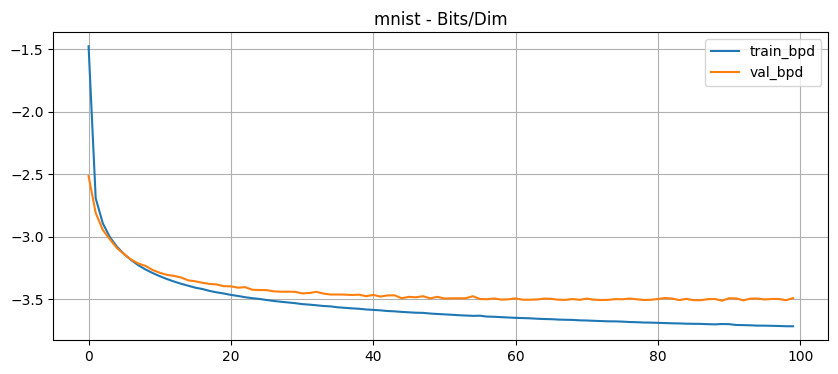

In [11]:
EPOCHS = 100
mnist_model, mnist_hist = run_experiment("mnist")


🚀 Running RealNVP on: fashionmnist

Epoch 1/50
batch 0/211 loss=801.3162
batch 200/211 loss=-933.8709


train_nll=-476.2669  train_bpd=-0.876413
val_nll  =-932.4348  val_bpd  =-1.715841


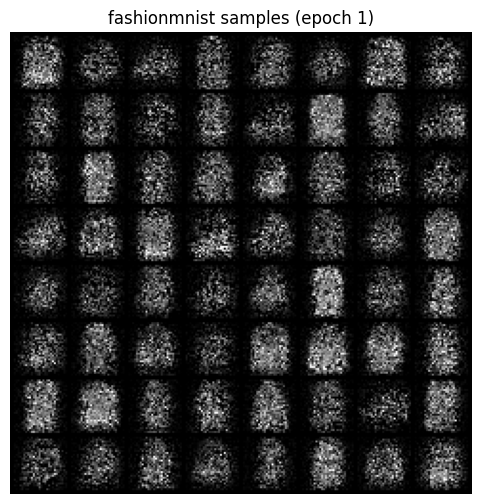


Epoch 2/50
batch 0/211 loss=-976.5273
batch 200/211 loss=-1078.5969
train_nll=-1025.2235  train_bpd=-1.886588
val_nll  =-1076.8005  val_bpd  =-1.981498

Epoch 3/50
batch 0/211 loss=-1084.6360
batch 200/211 loss=-1135.4731
train_nll=-1122.7087  train_bpd=-2.065977
val_nll  =-1142.5599  val_bpd  =-2.102507

Epoch 4/50
batch 0/211 loss=-1169.5983
batch 200/211 loss=-1184.2666
train_nll=-1178.0885  train_bpd=-2.167886
val_nll  =-1186.6504  val_bpd  =-2.183641

Epoch 5/50
batch 0/211 loss=-1194.4540
batch 200/211 loss=-1273.1178


train_nll=-1217.5802  train_bpd=-2.240557
val_nll  =-1218.0101  val_bpd  =-2.241348


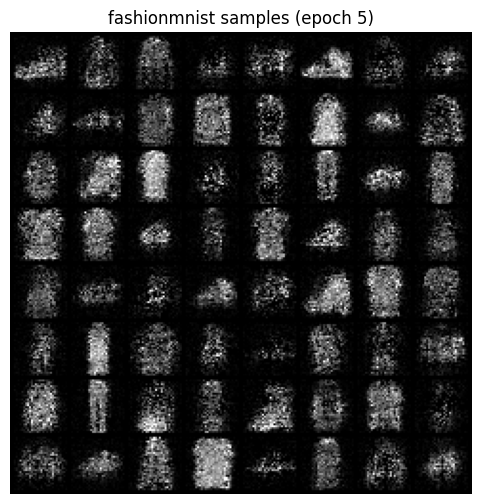


Epoch 6/50
batch 0/211 loss=-1266.5686
batch 200/211 loss=-1253.6368
train_nll=-1248.1101  train_bpd=-2.296738
val_nll  =-1243.1502  val_bpd  =-2.287610

Epoch 7/50
batch 0/211 loss=-1302.4700
batch 200/211 loss=-1288.4895
train_nll=-1273.3318  train_bpd=-2.343150
val_nll  =-1263.0379  val_bpd  =-2.324207

Epoch 8/50
batch 0/211 loss=-1272.1616
batch 200/211 loss=-1306.7264
train_nll=-1294.7742  train_bpd=-2.382608
val_nll  =-1281.6683  val_bpd  =-2.358490

Epoch 9/50
batch 0/211 loss=-1308.4187
batch 200/211 loss=-1347.6558
train_nll=-1313.3246  train_bpd=-2.416744
val_nll  =-1299.7905  val_bpd  =-2.391838

Epoch 10/50
batch 0/211 loss=-1316.0834
batch 200/211 loss=-1336.5620


train_nll=-1329.5870  train_bpd=-2.446669
val_nll  =-1313.0805  val_bpd  =-2.416294


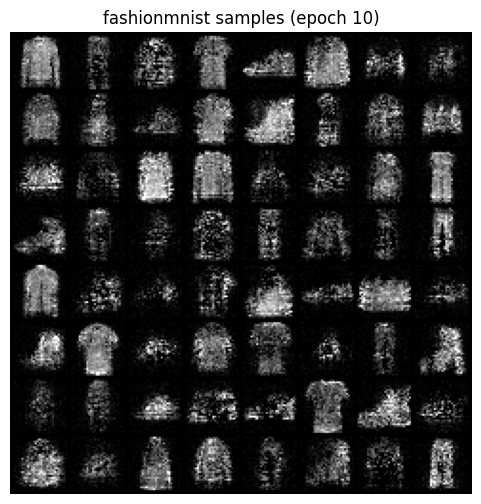


Epoch 11/50
batch 0/211 loss=-1347.7256
batch 200/211 loss=-1349.5620
train_nll=-1344.9884  train_bpd=-2.475010
val_nll  =-1327.8636  val_bpd  =-2.443498

Epoch 12/50
batch 0/211 loss=-1363.0221
batch 200/211 loss=-1341.3424
train_nll=-1358.3141  train_bpd=-2.499532
val_nll  =-1336.0409  val_bpd  =-2.458545

Epoch 13/50
batch 0/211 loss=-1368.5745
batch 200/211 loss=-1404.4761
train_nll=-1369.6208  train_bpd=-2.520338
val_nll  =-1344.5336  val_bpd  =-2.474173

Epoch 14/50
batch 0/211 loss=-1388.4658
batch 200/211 loss=-1409.2842
train_nll=-1380.3762  train_bpd=-2.540130
val_nll  =-1355.8505  val_bpd  =-2.494998

Epoch 15/50
batch 0/211 loss=-1372.4900
batch 200/211 loss=-1358.9873


train_nll=-1391.7354  train_bpd=-2.561033
val_nll  =-1366.3035  val_bpd  =-2.514234


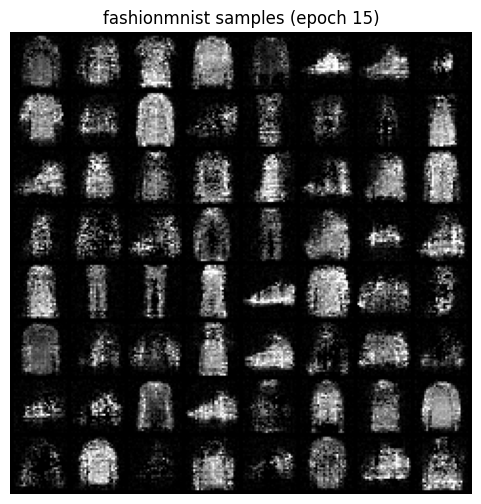


Epoch 16/50
batch 0/211 loss=-1394.6544
batch 200/211 loss=-1433.7322
train_nll=-1401.7777  train_bpd=-2.579512
val_nll  =-1371.4645  val_bpd  =-2.523731

Epoch 17/50
batch 0/211 loss=-1424.2795
batch 200/211 loss=-1413.1439
train_nll=-1409.2650  train_bpd=-2.593290
val_nll  =-1377.6631  val_bpd  =-2.535137

Epoch 18/50
batch 0/211 loss=-1384.2388
batch 200/211 loss=-1399.2941
train_nll=-1417.6926  train_bpd=-2.608798
val_nll  =-1386.2850  val_bpd  =-2.551003

Epoch 19/50
batch 0/211 loss=-1444.5244
batch 200/211 loss=-1434.9751
train_nll=-1425.6535  train_bpd=-2.623448
val_nll  =-1389.6090  val_bpd  =-2.557120

Epoch 20/50
batch 0/211 loss=-1476.0262
batch 200/211 loss=-1456.4297


train_nll=-1433.3884  train_bpd=-2.637681
val_nll  =-1393.9756  val_bpd  =-2.565155


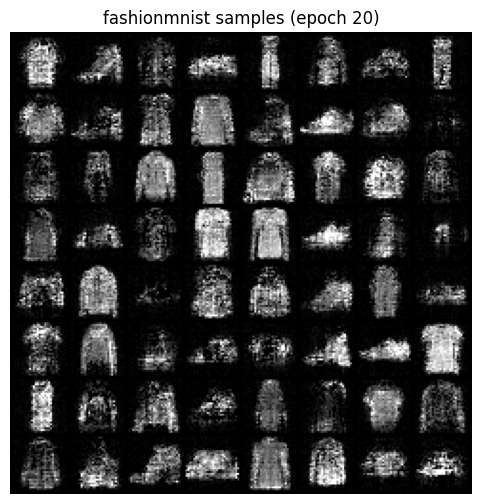


Epoch 21/50
batch 0/211 loss=-1441.9069
batch 200/211 loss=-1453.8171
train_nll=-1440.4864  train_bpd=-2.650743
val_nll  =-1395.8209  val_bpd  =-2.568551

Epoch 22/50
batch 0/211 loss=-1459.2452
batch 200/211 loss=-1419.2856
train_nll=-1446.3502  train_bpd=-2.661534
val_nll  =-1409.1754  val_bpd  =-2.593126

Epoch 23/50
batch 0/211 loss=-1447.2435
batch 200/211 loss=-1430.2229
train_nll=-1452.8475  train_bpd=-2.673490
val_nll  =-1413.0675  val_bpd  =-2.600288

Epoch 24/50
batch 0/211 loss=-1490.5894
batch 200/211 loss=-1459.5198
train_nll=-1458.9752  train_bpd=-2.684766
val_nll  =-1412.8752  val_bpd  =-2.599934

Epoch 25/50
batch 0/211 loss=-1463.6470
batch 200/211 loss=-1431.1180


train_nll=-1464.4847  train_bpd=-2.694904
val_nll  =-1417.2500  val_bpd  =-2.607984


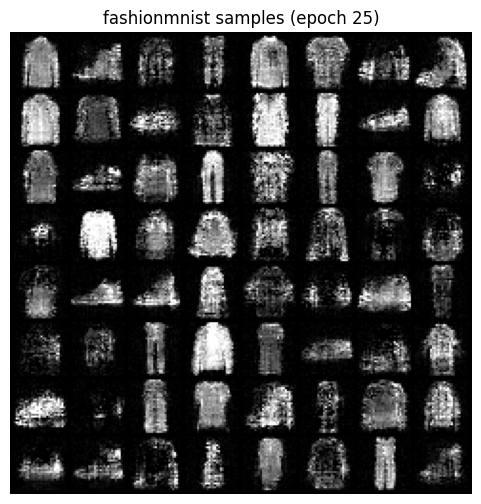


Epoch 26/50
batch 0/211 loss=-1466.7400
batch 200/211 loss=-1487.7788
train_nll=-1470.9738  train_bpd=-2.706845
val_nll  =-1425.1509  val_bpd  =-2.622523

Epoch 27/50
batch 0/211 loss=-1424.6232
batch 200/211 loss=-1470.0488
train_nll=-1475.8549  train_bpd=-2.715827
val_nll  =-1428.6215  val_bpd  =-2.628910

Epoch 28/50
batch 0/211 loss=-1492.0616
batch 200/211 loss=-1484.8990
train_nll=-1479.7674  train_bpd=-2.723027
val_nll  =-1432.3012  val_bpd  =-2.635681

Epoch 29/50
batch 0/211 loss=-1505.5869
batch 200/211 loss=-1484.8563
train_nll=-1485.0408  train_bpd=-2.732731
val_nll  =-1436.3467  val_bpd  =-2.643125

Epoch 30/50
batch 0/211 loss=-1468.4935
batch 200/211 loss=-1499.3286


train_nll=-1490.9529  train_bpd=-2.743610
val_nll  =-1437.0818  val_bpd  =-2.644478


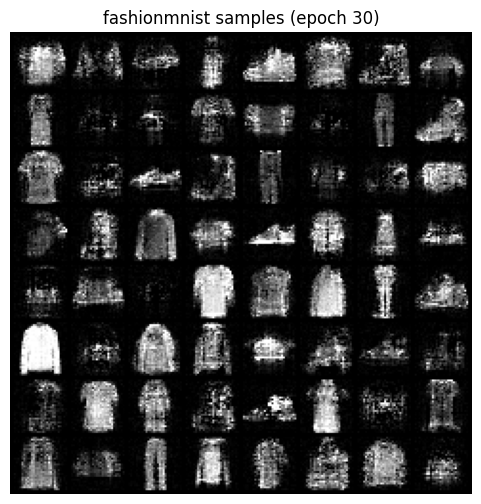


Epoch 31/50
batch 0/211 loss=-1517.5500
batch 200/211 loss=-1510.6547
train_nll=-1494.3696  train_bpd=-2.749897
val_nll  =-1433.0569  val_bpd  =-2.637072

Epoch 32/50
batch 0/211 loss=-1537.7100
batch 200/211 loss=-1481.8905
train_nll=-1499.2895  train_bpd=-2.758951
val_nll  =-1443.2941  val_bpd  =-2.655910

Epoch 33/50
batch 0/211 loss=-1499.7822
batch 200/211 loss=-1476.3982
train_nll=-1503.5268  train_bpd=-2.766748
val_nll  =-1442.3845  val_bpd  =-2.654236

Epoch 34/50
batch 0/211 loss=-1467.6993
batch 200/211 loss=-1494.0171
train_nll=-1507.1987  train_bpd=-2.773505
val_nll  =-1451.1491  val_bpd  =-2.670364

Epoch 35/50
batch 0/211 loss=-1494.8604
batch 200/211 loss=-1504.1824


train_nll=-1511.0821  train_bpd=-2.780651
val_nll  =-1449.9706  val_bpd  =-2.668196


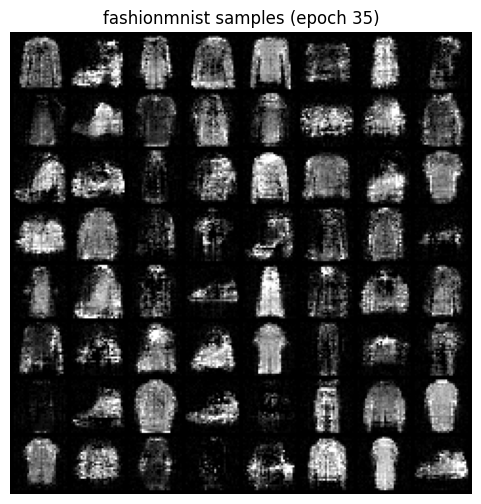


Epoch 36/50
batch 0/211 loss=-1501.6951
batch 200/211 loss=-1503.6543
train_nll=-1515.7848  train_bpd=-2.789305
val_nll  =-1453.0347  val_bpd  =-2.673834

Epoch 37/50
batch 0/211 loss=-1544.9736
batch 200/211 loss=-1500.3630
train_nll=-1519.3212  train_bpd=-2.795813
val_nll  =-1452.7955  val_bpd  =-2.673394

Epoch 38/50
batch 0/211 loss=-1532.4270
batch 200/211 loss=-1510.9857
train_nll=-1522.7674  train_bpd=-2.802154
val_nll  =-1463.4632  val_bpd  =-2.693024

Epoch 39/50
batch 0/211 loss=-1558.7174
batch 200/211 loss=-1509.5953
train_nll=-1524.6873  train_bpd=-2.805687
val_nll  =-1463.9280  val_bpd  =-2.693880

Epoch 40/50
batch 0/211 loss=-1542.8102
batch 200/211 loss=-1513.2676


train_nll=-1529.8089  train_bpd=-2.815112
val_nll  =-1462.7263  val_bpd  =-2.691668


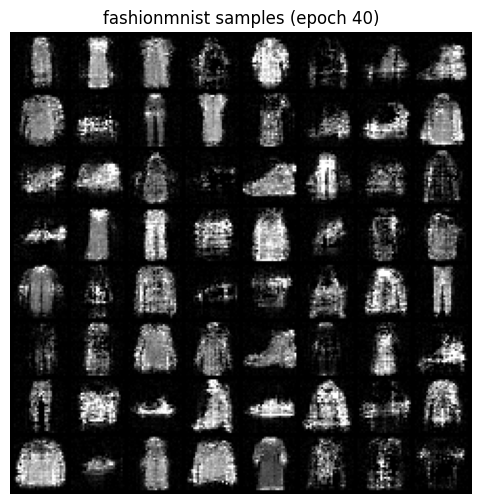


Epoch 41/50
batch 0/211 loss=-1520.1501
batch 200/211 loss=-1518.2742
train_nll=-1533.0007  train_bpd=-2.820985
val_nll  =-1457.8807  val_bpd  =-2.682752

Epoch 42/50
batch 0/211 loss=-1543.1681
batch 200/211 loss=-1533.6575
train_nll=-1536.6479  train_bpd=-2.827697
val_nll  =-1470.4041  val_bpd  =-2.705797

Epoch 43/50
batch 0/211 loss=-1539.8650
batch 200/211 loss=-1549.2345
train_nll=-1539.7732  train_bpd=-2.833448
val_nll  =-1468.7330  val_bpd  =-2.702722

Epoch 44/50
batch 0/211 loss=-1569.7424
batch 200/211 loss=-1542.6970
train_nll=-1542.0098  train_bpd=-2.837564
val_nll  =-1475.6664  val_bpd  =-2.715480

Epoch 45/50
batch 0/211 loss=-1526.9220
batch 200/211 loss=-1585.6478


train_nll=-1545.7926  train_bpd=-2.844525
val_nll  =-1471.1593  val_bpd  =-2.707187


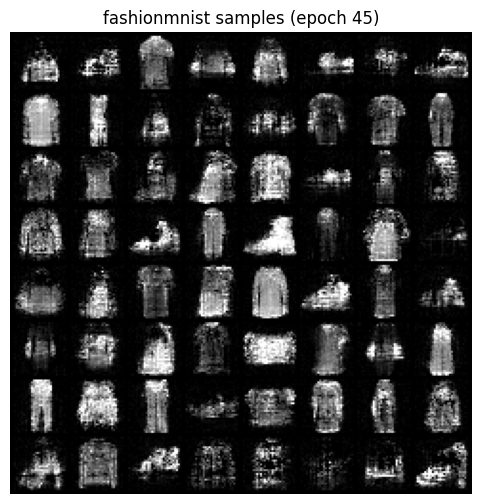


Epoch 46/50
batch 0/211 loss=-1559.9465
batch 200/211 loss=-1558.5839
train_nll=-1547.5205  train_bpd=-2.847704
val_nll  =-1473.0294  val_bpd  =-2.710628

Epoch 47/50
batch 0/211 loss=-1545.3790
batch 200/211 loss=-1589.4055
train_nll=-1552.2081  train_bpd=-2.856330
val_nll  =-1473.9694  val_bpd  =-2.712358

Epoch 48/50
batch 0/211 loss=-1551.3004
batch 200/211 loss=-1557.7212
train_nll=-1555.1061  train_bpd=-2.861663
val_nll  =-1472.5460  val_bpd  =-2.709738

Epoch 49/50
batch 0/211 loss=-1581.1704
batch 200/211 loss=-1549.1661
train_nll=-1556.7356  train_bpd=-2.864662
val_nll  =-1475.3340  val_bpd  =-2.714869

Epoch 50/50
batch 0/211 loss=-1586.7480
batch 200/211 loss=-1544.7059


train_nll=-1559.5513  train_bpd=-2.869843
val_nll  =-1486.4565  val_bpd  =-2.735336


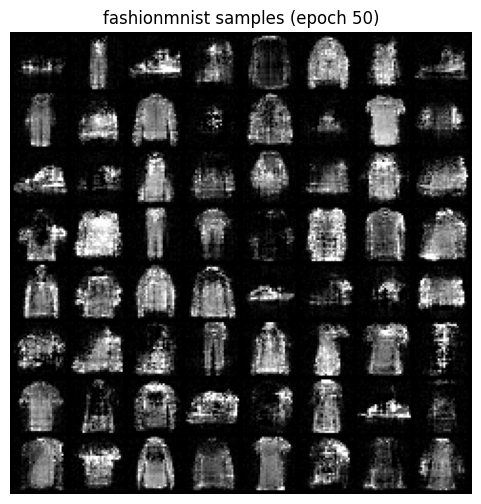


Final TEST metrics:
test_nll=-1490.6959
test_bpd=-2.743137


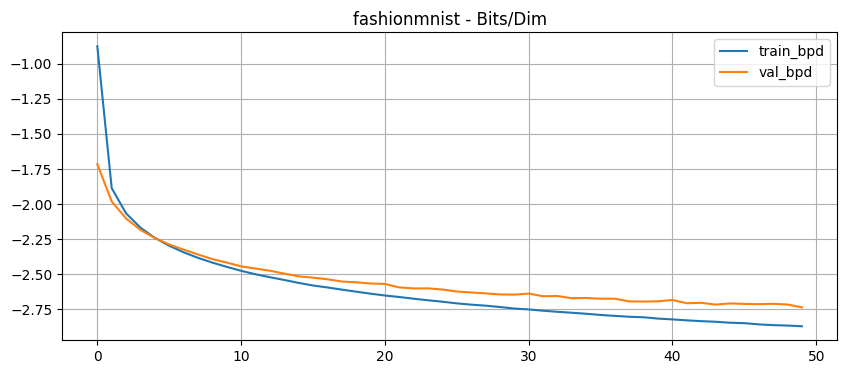

In [9]:
EPOCHS = 50
fashion_model, fashion_hist = run_experiment("fashionmnist")